Subspace alignment score: 0.4999


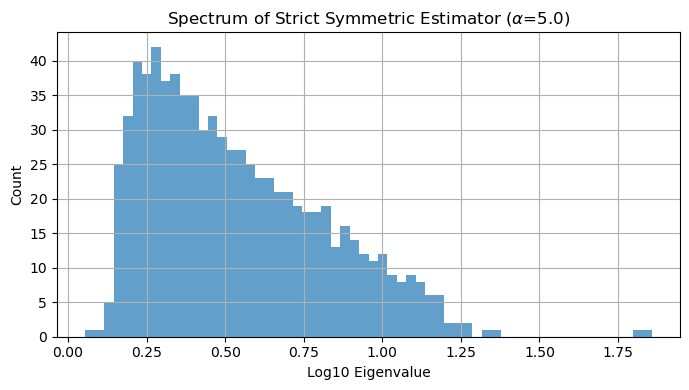


[Individual Eigenvector Alignment Scores]
      Type        λ  Alignment Score
0  eig1992  11.4846           0.0237
1  eig1993  11.6467           0.0192
2  eig1994  11.7092           0.0451
3  eig1995  11.7515           0.0409
4  eig1996  12.0398           0.0062
5  eig1997  12.4755           0.0286
6  eig1998  12.9617           0.3478
7  eig1999  14.3322           0.3746

[Eigenvector Pair Subspace Alignment Scores]
               Type                  λ Pair  Alignment Score
0   eig1992+eig1993  (11.484554, 11.646711)           0.0260
1   eig1992+eig1994  (11.484554, 11.709238)           0.0387
2   eig1992+eig1995  (11.484554, 11.751511)           0.0427
3   eig1992+eig1996  (11.484554, 12.039775)           0.0224
4   eig1992+eig1997    (11.484554, 12.4755)           0.0301
5   eig1992+eig1998   (11.484554, 12.96169)           0.3407
6   eig1992+eig1999  (11.484554, 14.332246)           0.3677
7   eig1993+eig1994  (11.646711, 11.709238)           0.0348
8   eig1993+eig1995  (11.6467

In [23]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 5000, 1000, 2
alpha = n / d
np.random.seed(42)
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using adjustable Bessel approximation ==========
def construct_T_y_adjustable(y_i, gamma=1, clip=1e-2, scale=5):
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)
    return torch.tensor([
        [r, gamma * y_scaled],
        [gamma * y_scaled, r]
    ], dtype=torch.float32)

# ========== Step 3: Construct Spectral Matrix ==========
I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y_adjustable(y[i], gamma=1, clip=1e-2, scale=5.0)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 4: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 5: Subspace Alignment Score ==========
def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

U_top_np = U_top.numpy()
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
Q1, _ = np.linalg.qr(U_top_np)
Q2, _ = np.linalg.qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print("Subspace alignment score:", round(subspace_score, 4))

# ========== Step 6: Plot Spectrum ==========
eigvals_np = eigvals_sym.numpy()
eigvals_pos = eigvals_np[eigvals_np > 1e-12]  # 排除非正值（含 0）


positive_eigs = eigvals[eigvals > 1e-12]
plt.figure(figsize=(7, 4))
plt.hist(positive_eigs, bins=60, alpha=0.7)
plt.title(f"Spectrum of Strict Symmetric Estimator ($\\alpha$={alpha:.1f})")
plt.xlabel("Log10 Eigenvalue")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


# ========== Step 7: Unified Evaluation ==========

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
    W_normed = W_sym / torch.norm(W_sym, dim=0, keepdim=True)

    indices = np.argsort(eig_vals)[-top_k:]
    individual_scores = []

    for i in indices:
        vec = eig_vecs[:, i]
        if mode == 'asymmetric':
            vec = elevate_vector(vec, position='top', d=d)
        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# ========== Step 8: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


In [21]:
# 跟上述代码的区别是将单个谱估计reshape成适合子空间的维度后，评估恢复子空间情况的评估，而不是单个谱估计器的单个方向的评估

for i in range(10):
    v = eigvecs_np[:, -1 - i]
    V = v.reshape(2, d).T  # reshape back to d×2
    Q1, _ = np.linalg.qr(V)
    Q2, _ = np.linalg.qr(W_star.numpy())
    overlap = Q1.T @ Q2
    align_score = np.linalg.norm(overlap, 'fro')**2 / p
    print(f"eig{len(eigvals_np)-1-i}: align score = {align_score:.4f}")


eig1999: align score = 0.2571
eig1998: align score = 0.2435
eig1997: align score = 0.1567
eig1996: align score = 0.0208
eig1995: align score = 0.0703
eig1994: align score = 0.0222
eig1993: align score = 0.0154
eig1992: align score = 0.0012
eig1991: align score = 0.0009
eig1990: align score = 0.0019


Subspace alignment score: 0.714


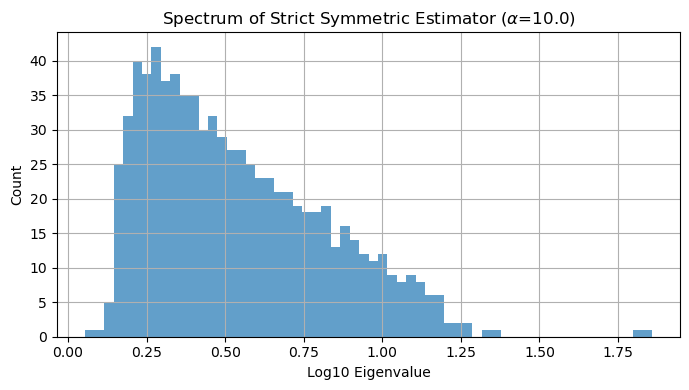


[Individual Eigenvector Alignment Scores]
     Type        λ  Alignment Score
0  eig992   8.3133           0.0017
1  eig993   8.3867           0.0058
2  eig994   8.5626           0.0005
3  eig995   8.6042           0.0125
4  eig996   8.7357           0.0285
5  eig997   8.9468           0.0094
6  eig998  10.8005           0.7067
7  eig999  12.0781           0.6769

[Eigenvector Pair Subspace Alignment Scores]
             Type                   λ Pair  Alignment Score
0   eig992+eig993     (8.313285, 8.386675)           0.0205
1   eig992+eig994     (8.313285, 8.562601)           0.0180
2   eig992+eig995    (8.313285, 8.6041975)           0.0294
3   eig992+eig996     (8.313285, 8.735698)           0.0185
4   eig992+eig997    (8.313285, 8.9468155)           0.0663
5   eig992+eig998   (8.313285, 10.8005495)           0.4157
6   eig992+eig999    (8.313285, 12.078115)           0.4297
7   eig993+eig994     (8.386675, 8.562601)           0.0099
8   eig993+eig995    (8.386675, 8.6041975)     

In [51]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 5000, 500, 2
alpha = n / d
np.random.seed(42)
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using adjustable Bessel approximation ==========
def construct_T_y_adjustable(y_i, gamma=1, clip=1e-2, scale=5):
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)
    return torch.tensor([
        [r, gamma * y_scaled],
        [gamma * y_scaled, r]
    ], dtype=torch.float32)

# ========== Step 3: Construct Spectral Matrix ==========
I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y_adjustable(y[i], gamma=1, clip=1e-2, scale=5.0)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 4: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 5: Subspace Alignment Score ==========
def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

U_top_np = U_top.numpy()
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
Q1, _ = np.linalg.qr(U_top_np)
Q2, _ = np.linalg.qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print("Subspace alignment score:", round(subspace_score, 4))

# ========== Step 6: Plot Spectrum ==========
eigvals_np = eigvals_sym.numpy()
eigvals_pos = eigvals_np[eigvals_np > 1e-12]  # 排除非正值（含 0）

plt.figure(figsize=(7, 4))
plt.hist(positive_eigs, bins=60, alpha=0.7)
plt.title(f"Spectrum of Strict Symmetric Estimator ($\\alpha$={alpha:.1f})")
plt.xlabel("Log10 Eigenvalue")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


# ========== Step 7: Unified Evaluation ==========

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    Q_true, _ = np.linalg.qr(W_sym_np[:, :p])  # ✅ 正确使用 p=2 维的信号空间


    indices = np.argsort(eig_vals)[-top_k:]
    individual_scores = []

    for i in indices:
        vec = eig_vecs[:, i]  # 取一个谱向量 (2d,)
        
        # === reshape 为 d × 2 的矩阵 ===
        try:
            V = vec.reshape(2, d).T  # 变为 d × 2
        except:
            print(f"Error reshaping eigenvector {i}, shape = {vec.shape}")
            continue

        # === 升维为 2d × 2，与真实空间对齐 ===
        W_est = elevate_W_star_to_symmetric(V)  # (2d × 2)
        Q_est, _ = np.linalg.qr(W_est)
        overlap = Q_est.T @ Q_true
        align_score = np.linalg.norm(overlap, 'fro')**2 / p
        individual_scores.append((f"eig{i}", eig_vals[i], align_score))

        

    # === pairwise 部分不变 ===
    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df


# ========== Step 8: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))
